In [1]:
import os
import json
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_error

data_path = os.getcwd() + '/Data/'
logs_path = os.getcwd() + '/Logs/'

data = pd.read_csv(data_path + 'vni30.csv')
data = data.drop(['Unnamed: 0'], axis=1)
data['date'] = data['date'].astype('datetime64')
data = data.set_index(['date'])
data = data.sort_values(['date'])

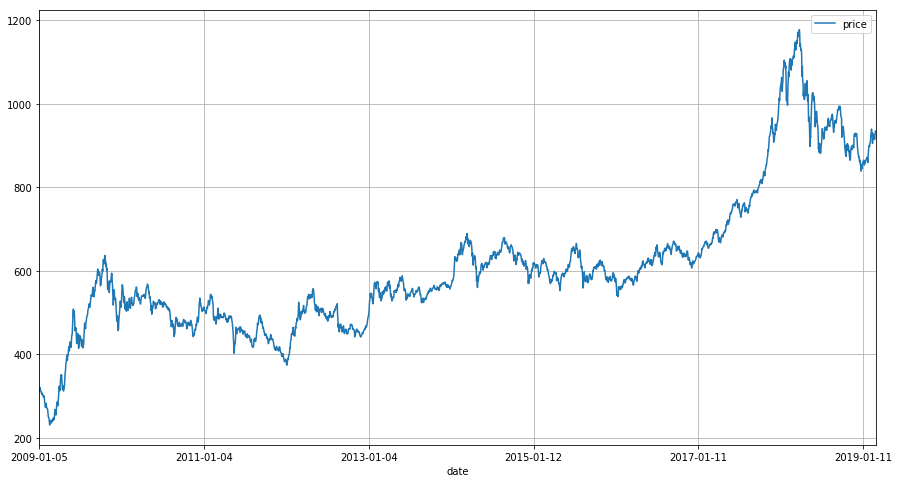

In [2]:
data.plot(figsize=(15,8), grid=True)
plt.show()

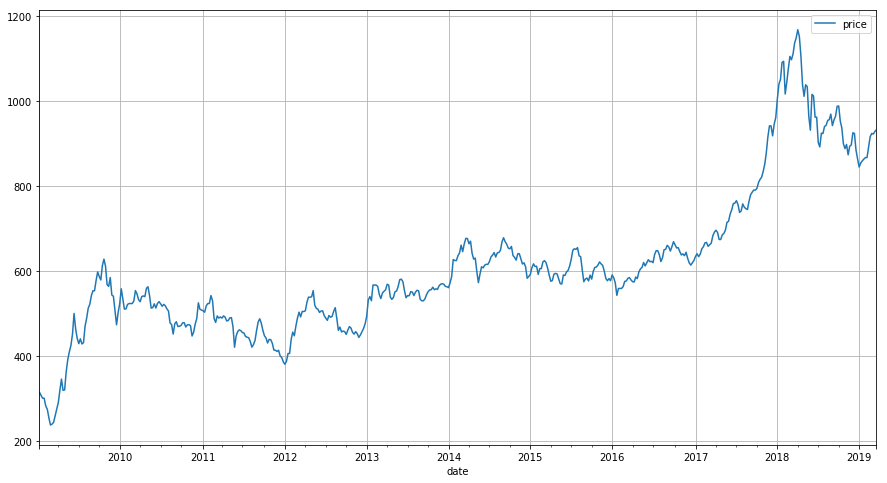

In [34]:
offset = pd.offsets.timedelta(days=-6)
weekly_data = data.resample('W-FRI').mean().fillna(method='ffill')
weekly_data.plot(figsize=(15,8), grid=True)
plt.show()

In [33]:
weekly_data[weekly_data['price'] == np.nan]

,price
date,


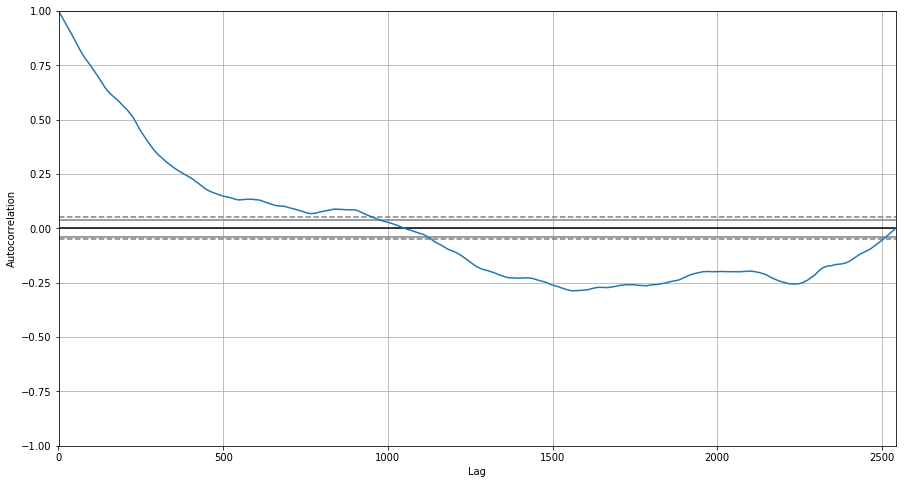

In [3]:
plt.figure(figsize=(15,8))
autocorrelation_plot(data)
plt.show()

In [4]:
# fit model
model = ARIMA(data, order=(5,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())

/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                D.price   No. Observations:                 2541
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -8819.084
Method:                       css-mle   S.D. of innovations              7.782
Date:                Wed, 03 Apr 2019   AIC                          17652.168
Time:                        22:11:01   BIC                          17693.050
Sample:                             1   HQIC                         17666.998
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.2450      0.184      1.330      0.184      -0.116       0.606
ar.L1.D.price     0.0758      0.020      3.821      0.000       0.037       0.115
ar.L2.D.price     0.0572      0.020     

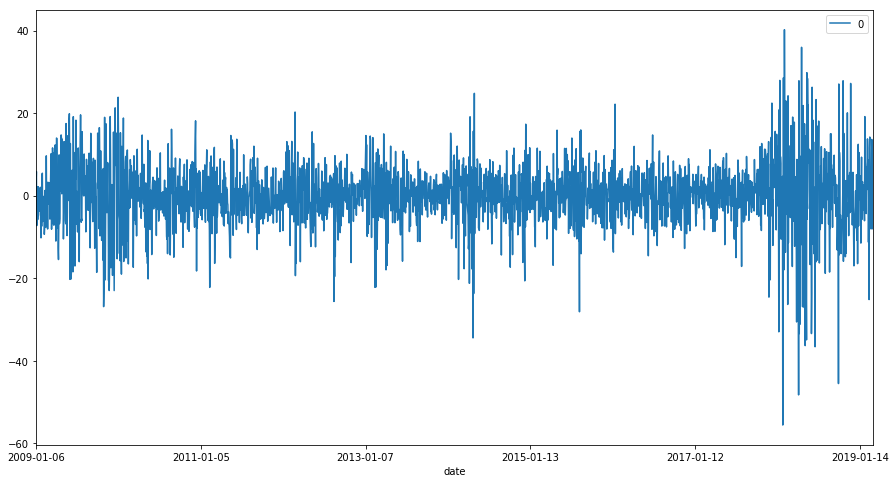

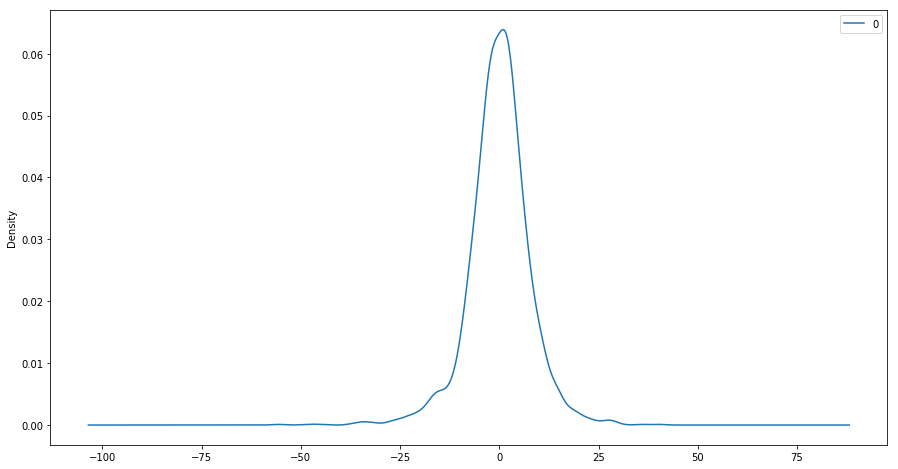

                 0
count  2541.000000
mean     -0.000307
std       7.783210
min     -55.585743
25%      -3.869038
50%       0.219447
75%       4.189251
max      40.243909


In [5]:
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot(figsize=(15,8))
plt.show()
residuals.plot(figsize=(15,8), kind='kde')
plt.show()
print(residuals.describe())

### One-step prediction

In [6]:
size = len(data)
train_start = int(0.6 * size)
train_end = int(0.9 * size)
train, test = data[train_start:train_end], data[train_end:]
history_data = [price for price in train['price']]
predictions = list()
for t in tqdm(range(len(test)+1)):
    model = ARIMA(history_data, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    predictions.append(output[0][0])
    if t < len(test):
        obs = test['price'][t]
        history_data.append(obs)

100%|██████████| 256/256 [00:35<00:00,  7.34it/s]


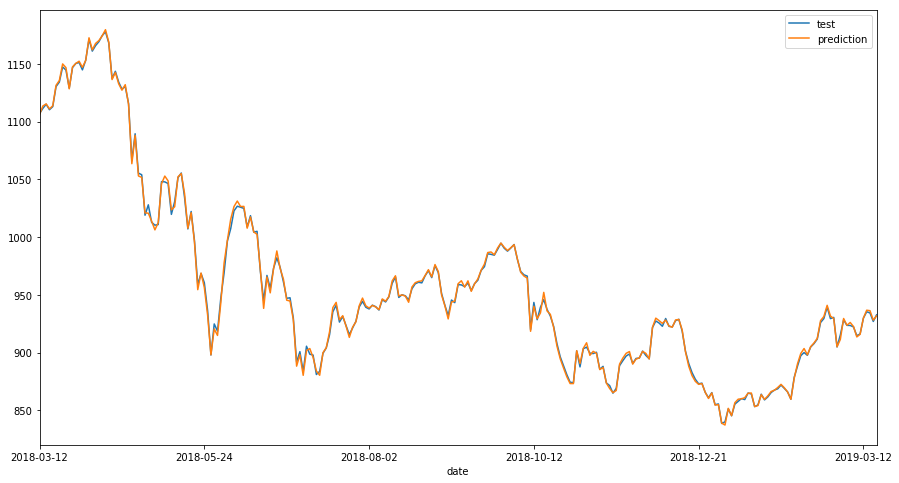

In [7]:
validation = pd.DataFrame()
validation['test'] = test['price']
validation['prediction'] = predictions[1:]
validation.plot(figsize=(15,8))
plt.show()

In [8]:
# Evaluation
mse = mean_squared_error(test['price'], predictions[1:])
print(mse)

4.4747259685393965


### Multi-step prediction

In [ ]:
def multi_step_predict(data, n_step=5):
    predictions = list()
    for t in tqdm(range(n_step+1)):
        model = ARIMA(data, order=(5,1,0))
        model_fit= model.fit(disp=0)
        output = model_fit.forecast()
        yhat = output[0][0]
        predictions.append(yhat)
        if t < n_step:
            data.append(yhat)
    return predictions

100%|██████████| 101/101 [00:11<00:00,  9.25it/s]


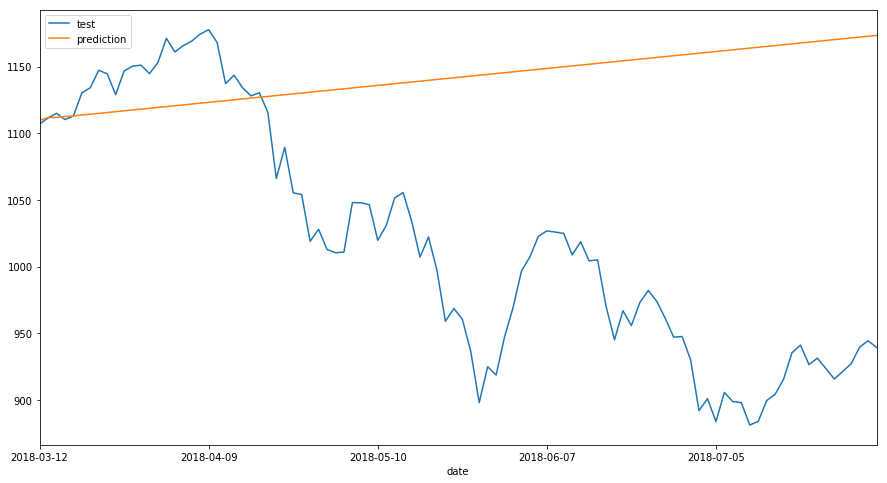

In [ ]:
n_step = 100
train, test = data[train_start:train_end], data[train_end:]
history_data = [price for price in train['price']]
predictions = multi_step_predict(history_data, n_step)

validation = pd.DataFrame()
validation['test'] = test['price'][:n_step]
validation['prediction'] = predictions[1:]
validation.plot(figsize=(15,8))
plt.show()

## Run experiments
Try multiple order parameters to find the best parameters for model of data

In [9]:
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true-y_pred)/y_true)) * 100

def experiment_predict(training_data, testing_data, order=(5,1,0)):
    history_data = list(training_data)
    predictions = list()
    for t in tqdm(range(len(test)+1)):
        model = ARIMA(history_data, order=order)
        model_fit = model.fit(disp=0)
        output = model_fit.forecast()
        predictions.append(output[0][0])
        if t < len(test):
            obs = test['price'][t]
            history_data.append(obs)
    return predictions

def evaluation(validation):
    mse = mean_squared_error(validation['ground_true'], validation['prediction'])
    mae = mean_absolute_error(validation['ground_true'], validation['prediction'])
    mape = mean_absolute_percentage_error(validation['ground_true'], validation['prediction'])
    return mse, mae, mape

def experiment_logs(experiment_results):
    with open(logs_path + 'experiment_logs.txt', 'a') as fout:
        json.dump(experiment_results, fout)
        
def gen_params():
    q = range(1, 5)
    d = range(1, 2)
    p = range(0, 5)
    return list(itertools.product(q, d, p))

In [10]:
# def run_experiment(data, start_train=0.6, end_train=0.95):
#     # Split data
#     size = len(data)
#     train_start = int(start_train * size)
#     train_end = int(end_train * size)
#     train, test = data[train_start:train_end], data[train_end:]
    
#     # Generate parameters
#     params = gen_params()
    
#     # Run experiments
#     result_lst = []
#     for param in params:
#         try:
#             result = {'param': param}
#             print('Order:', param)

#             # Prediction
#             predictions = experiment_predict(train['price'].values, test['price'].values, order=param)

#             # Evaluation
#             validation = pd.DataFrame()
#             validation['ground_true'] = test
#             validation['prediction'] = predictions
#             mse, mae, mape = evaluation(validation)
#             result['mse'] = mse
#             result['mae'] = mae
#             result['mape'] = mape
#             result_lst.append(result)
#         except:
#             continue
    
#     # Record experiment results
#     experiment_logs(result_lst)
#     return result_lst

In [ ]:
def run_experiment(data, start_train=0.6, end_train=0.95):
    daily_data = data
    weekly_data = data.resample('W').mean()
    monthly_data = data.resample('M').mean()
    
    pass

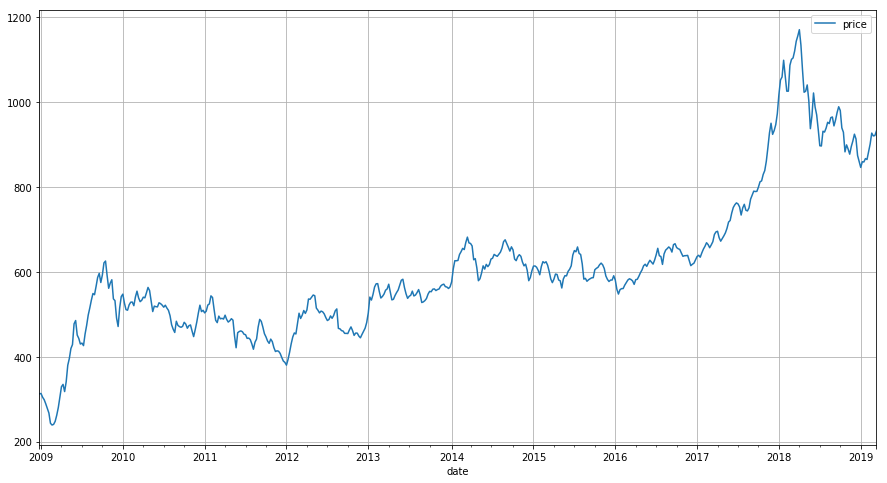

In [35]:
offset = pd.offsets.timedelta(days=-7)
weekly_data = data.resample('W-TUE', loffset=offset).mean().fillna(method='ffill')
weekly_data.plot(figsize=(15,8), grid=True)
plt.show()